# **Standard Gym Blackjack Environment Info**

In [ ]:
import gym

env = gym.make('Blackjack-v1', natural=False, sab=False)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("Reward range:", env.reward_range)

Observation space: Tuple(Discrete(32), Discrete(11), Discrete(2))
Action space: Discrete(2)
Reward range: (-inf, inf)


# **Environment**

In [56]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from datetime import datetime

def cmp(a, b):
    return float(a > b) - float(a < b)

def display_hand(hand):
    return f"{hand} ({sum_hand(hand)})"

def usable_ace(hand):
    return int(1 in hand and sum(hand) + 10 <= 21)

def sum_hand(hand):
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)

def is_bust(hand):
    return sum_hand(hand) > 21


class BlackjackDeck:
    def __init__(self, np_random=None):
        self.np_random = np_random or np.random.RandomState()
        self._reshuffle_history = []
        self._reshuffled_since_last_hand = False
        self._build_full_deck()
        self.original_deck_size = len(self.deck)

    def _build_full_deck(self):
        """
        Build and shuffle a new full deck, reset counts and log event.
        """
        self.deck = (
            [1] * 4 +
            [2] * 4 + [3] * 4 + [4] * 4 + [5] * 4 +
            [6] * 4 + [7] * 4 + [8] * 4 + [9] * 4 +
            [10] * 16  # Tens, Jacks, Queens, Kings
        )
        self.np_random.shuffle(self.deck)
        timestamp = datetime.now()
        self._reshuffle_history.append(timestamp)
        self._reshuffled_since_last_hand = True
        self._init_card_counts()

    def _init_card_counts(self):
        """
        Initialize the card count dictionary based on the fresh deck.
        """
        self._card_counts = {}
        for card in self.deck:
            self._card_counts[card] = self._card_counts.get(card, 0) + 1

    def check_and_reshuffle(self):
        """
        Check if deck needs reshuffling at start of new game (reset).
        Only reshuffle if fewer than 30% of original cards remain.
        """
        remaining = len(self.deck)
        percent = remaining / self.original_deck_size * 100
        ts = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        #print(f"[{ts}] Checking reshuffle: {percent:.2f}% cards remaining ({remaining}/{self.original_deck_size})")
        if percent < 30.0:
            #print(f"Threshold met (<30%). Reshuffling deck...")
            #pre_counts = dict(self._card_counts)
            #print("Pre-reshuffle counts:")
            #for val in sorted(pre_counts):
                #print(f"  {val:>2}: {pre_counts[val]:>2}")
            # Perform a full reshuffle
            self._build_full_deck()
            #post_counts = dict(self._card_counts)
            #print("Post-reshuffle counts:")
            #for val in sorted(post_counts):
                #print(f"  {val:>2}: {post_counts[val]:>2}")
        #else:
            #print(f"Threshold not met. Deck remains as is.")

    def draw_card(self):
        """
        Draw a single card from the deck. If deck is low (<20 cards), reshuffle.
        Updates the card counts accordingly.
        """
        if len(self.deck) < 20:
            self._build_full_deck()
        card = self.deck.pop()
        self._card_counts[card] -= 1
        return card

    def draw_hand(self):
        """
        Draw two cards to form an initial hand.
        """
        return [self.draw_card(), self.draw_card()]

    def get_current_counts(self):
        """
        Return a dictionary mapping each card value (1-10) to the
        number of remaining cards of that value in the deck.
        """
        return dict(self._card_counts)

    def has_reshuffled_since_last_hand(self):
        """
        Check if the deck has been reshuffled since the last hand.
        Returns True if at least one reshuffle has happened; False otherwise.
        """
        return self._reshuffled_since_last_hand

    def clear_reshuffled_flag(self):
        """
        Clear the internal reshuffle flag. Call this at the start of a new hand
        to reset the "has reshuffled" status.
        """
        self._reshuffled_since_last_hand = False

    def get_reshuffle_history(self):
        """
        Return a list of datetime timestamps for each reshuffle event.
        """
        return list(self._reshuffle_history)


class BlackjackNewEnv(gym.Env):
    """
    Initialize the Blackjack environment with or without sab rules.
    Sets up action and observation spaces, random seed, and peek parameters.
    """

    stand = 0
    hit = 1
    peek = 2

    def __init__(self, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Discrete(11)
        ))
        self.sab = sab
        self.seed()
        self.peeked_card = None
        self.has_peeked = False
        self.total_reward = 0.0
        self.peek_success_prob = 0.85

    def seed(self, seed=None):
        """
        Seed the random number generator and initialize the deck.
        Returns the used seed.
        """
        self.np_random, seed = seeding.np_random(seed)
        self.deck = BlackjackDeck(self.np_random)
        return [seed]

    def step(self, action):
        """
        Apply the given action (stand, hit, or peek), update game state,
        and return observation, reward (cumulative if done), and done flag.
        """
        assert self.action_space.contains(action)

        reward = 0.0

        if action == self.stand:
            done = True
            while sum_hand(self.dealer) < 17:
                if self.peeked_card is not None:
                    self.dealer.append(self.peeked_card)
                    self.peeked_card = None
                else:
                    self.dealer.append(self.deck.draw_card())
            reward = 1.0 if is_bust(self.dealer) else cmp(sum_hand(self.player), sum_hand(self.dealer))

        elif action == self.hit:
            if self.peeked_card is not None:
                self.player.append(self.peeked_card)
                self.peeked_card = None
            else:
                self.player.append(self.deck.draw_card())
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0

        elif action == self.peek:
            if self.peeked_card is None:
                self.has_peeked = True
                if self.np_random.random() < self.peek_success_prob:
                    self.peeked_card = self.deck.draw_card()
                    #print(f"[SUCCESS] Peek probability: {self.peek_success_prob:.2%}")
                    reward = 0.0
                else:
                    reward = -1.0 # CHANGE HERE FOR TRAINING
                    self.peek_success_prob *= 0.6
            else:
                reward = 0.0
            done = False

        self.total_reward += reward

        if done:
            reward = self.total_reward

        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        """
        Return the current observation: player sum, dealer upcard,
        usable ace flag, and peeked card value.
        """
        peeked_value = 0 if self.peeked_card is None else self.peeked_card
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), peeked_value)

    def reset(self):
        """
        Reset the game state, shuffle deck if needed, and deal initial hands.
        Returns the initial observation.
        """
        self.deck.check_and_reshuffle()
        self.dealer = self.deck.draw_hand()
        self.player = self.deck.draw_hand()
        self.peeked_card = None
        self.has_peeked = False
        self.total_reward = 0.0
        return self._get_obs()

In [ ]:
env = BlackjackNewEnv()

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("Reward range:", env.reward_range)

Observation space: Tuple(Discrete(32), Discrete(11), Discrete(2), Discrete(11))
Action space: Discrete(3)
Reward range: (-inf, inf)


# **Baseline Strategy Development**

## **Random Strategy**

In [ ]:
import random
from datetime import datetime

def random_strategy(player_sum):
    """
    Select a random action from available moves.
    Possible actions: hit, stand, or peek.
    """
    return random.choice([BlackjackNewEnv.hit, BlackjackNewEnv.stand, BlackjackNewEnv.peek])

env = BlackjackNewEnv()
num_games = 1000000
rewards = []

for game in range(1, num_games + 1):
    print(f"\n--- Game {game} ---")
    obs = env.reset()

    if env.deck.has_reshuffled_since_last_hand():
        print(f"[{datetime.now().strftime('%H:%M:%S')}] Deck was reshuffled.")
        for ts in env.deck.get_reshuffle_history():
            print(f"  • reshuffle at {ts.strftime('%Y-%m-%d %H:%M:%S')}")
        env.deck.clear_reshuffled_flag()

    print("Starting card counts:")
    for val, cnt in sorted(env.deck.get_current_counts().items()):
        print(f"  {val:>2}: {cnt:>2}")

    player_hand = env.player
    dealer_hand = env.dealer
    print(f"\nPlayer hand: {display_hand(player_hand)}")
    print(f"Dealer hand: [{dealer_hand[0]}, ?]")

    done = False
    while not done:
        player_sum, dealer_card, has_usable_ace, peeked = obs
        action = random_strategy(player_sum)
        action_name = ["Stand", "Hit", "Peek"][action]
        print(f"\nAction: {action_name}")

        obs, reward, done, _ = env.step(action)

        if action == BlackjackNewEnv.hit:
            new_card = player_hand[-1]
            print(f"New card: {new_card}")
            print(f"Player hand: {display_hand(player_hand)}")
            if is_bust(player_hand):
                print("Player busts!")

        elif action == BlackjackNewEnv.stand:
            print("Player stands.")
            print(f"Dealer's full hand: {display_hand(dealer_hand)}")
            if is_bust(dealer_hand):
                print("Dealer busts!")

        elif action == BlackjackNewEnv.peek:
            peeked = env.peeked_card
            if peeked:
                print(f"Peek successful! Next card: {peeked}")
            else:
                print("Peek failed! No card revealed.")

    rewards.append(reward)

    print("Remaining counts:")
    for val, cnt in sorted(env.deck.get_current_counts().items()):
        print(f"  {val:>2}: {cnt:>2}")

    print(f"\nFinal Player hand: {display_hand(player_hand)}")
    print(f"Final Dealer hand: {display_hand(dealer_hand)}")
    print(f"Game Reward: {reward}")



--- Game 1 ---
[2025-07-11 12:06:05] Checking reshuffle: 100.00% cards remaining (52/52)
Threshold not met. Deck remains as is.
[12:06:05] Deck was reshuffled.
  • reshuffle at 2025-07-11 12:06:05
Starting card counts:
   1:  4
   2:  4
   3:  4
   4:  2
   5:  4
   6:  4
   7:  4
   8:  4
   9:  4
  10: 14

Player hand: [4, 4] (8)
Dealer hand: [10, ?]

Action: Peek
[SUCCESS] Peek probability: 85.00%
Peek successful! Next card: 8

Action: Peek
Peek successful! Next card: 8

Action: Peek
Peek successful! Next card: 8

Action: Hit
New card: 8
Player hand: [4, 4, 8] (16)

Action: Peek
[SUCCESS] Peek probability: 85.00%
Peek successful! Next card: 10

Action: Peek
Peek successful! Next card: 10

Action: Peek
Peek successful! Next card: 10

Action: Peek
Peek successful! Next card: 10

Action: Peek
Peek successful! Next card: 10

Action: Peek
Peek successful! Next card: 10

Action: Stand
Player stands.
Dealer's full hand: [10, 10] (20)
Remaining counts:
   1:  4
   2:  4
   3:  4
   4:  2
 

## **Basic Strategy**

In [25]:
import time
from datetime import datetime

random.seed(23)

def basic_strategy(player_sum, peeked):
    """
    Choose action based on a simple probabilistic rule set.
    Uses peeking information to decide whether to hit or stand.
    """
    if peeked == 0:
        if random.random() <= 0.8:
            return BlackjackNewEnv.hit if player_sum < 18 else BlackjackNewEnv.stand
        else:
            return BlackjackNewEnv.peek
    else:
        if player_sum + peeked <= 21:
            return BlackjackNewEnv.hit
        else:
            return BlackjackNewEnv.stand

env = BlackjackNewEnv()
num_games = 10
rewards = []

for game in range(1, num_games + 1):
    print(f"\n--- Game {game} ---")
    obs = env.reset()

    if env.deck.has_reshuffled_since_last_hand():
        print(f"[{datetime.now().strftime('%H:%M:%S')}] Deck was reshuffled.")
        for ts in env.deck.get_reshuffle_history():
            print(f"  • reshuffle at {ts.strftime('%Y-%m-%d %H:%M:%S')}")
        env.deck.clear_reshuffled_flag()

    print("Starting card counts:")
    for val, cnt in sorted(env.deck.get_current_counts().items()):
        print(f"  {val:>2}: {cnt:>2}")

    player_hand = env.player
    dealer_hand = env.dealer
    print(f"\nPlayer hand: {display_hand(player_hand)}")
    print(f"Dealer hand: [{dealer_hand[0]}, ?]")

    done = False
    while not done:
        player_sum, dealer_card, has_usable_ace, peeked = obs
        action = basic_strategy(player_sum, peeked)
        action_name = ["Stand", "Hit", "Peek"][action]
        print(f"\nAction: {action_name}")

        obs, reward, done, _ = env.step(action)

        if action == BlackjackNewEnv.hit:
            new_card = player_hand[-1]
            print(f"New card: {new_card}")
            print(f"Player hand: {display_hand(player_hand)}")
            if is_bust(player_hand):
                print("Player busts!")

        elif action == BlackjackNewEnv.stand:
            print("Player stands.")
            print(f"Dealer's full hand: {display_hand(dealer_hand)}")
            if is_bust(dealer_hand):
                print("Dealer busts!")

        elif action == BlackjackNewEnv.peek:
            peeked = env.peeked_card
            if peeked:
                print(f"Peek successful! Next card: {peeked}")
            else:
                print("Peek failed! No card revealed.")

    rewards.append(reward)

    print("Remaining counts:")
    for val, cnt in sorted(env.deck.get_current_counts().items()):
        print(f"  {val:>2}: {cnt:>2}")

    print(f"\nFinal Player hand: {display_hand(player_hand)}")
    print(f"Final Dealer hand: {display_hand(dealer_hand)}")
    print(f"Game Reward: {reward}")


--- Game 1 ---
[09:42:14] Deck was reshuffled.
  • reshuffle at 2025-07-14 09:42:14
Starting card counts:
   1:  4
   2:  4
   3:  3
   4:  4
   5:  4
   6:  4
   7:  3
   8:  4
   9:  4
  10: 14

Player hand: [7, 10] (17)
Dealer hand: [10, ?]

Action: Peek
Peek successful! Next card: 7

Action: Stand
Player stands.
Dealer's full hand: [10, 3, 7] (20)
Remaining counts:
   1:  4
   2:  4
   3:  3
   4:  4
   5:  4
   6:  4
   7:  2
   8:  4
   9:  4
  10: 14

Final Player hand: [7, 10] (17)
Final Dealer hand: [10, 3, 7] (20)
Game Reward: -1.0

--- Game 2 ---
Starting card counts:
   1:  4
   2:  4
   3:  3
   4:  3
   5:  3
   6:  2
   7:  2
   8:  4
   9:  4
  10: 14

Player hand: [5, 6] (11)
Dealer hand: [6, ?]

Action: Peek
Peek successful! Next card: 9

Action: Hit
New card: 9
Player hand: [5, 6, 9] (20)

Action: Peek
Peek successful! Next card: 10

Action: Stand
Player stands.
Dealer's full hand: [6, 4, 10] (20)
Remaining counts:
   1:  4
   2:  4
   3:  3
   4:  3
   5:  3
   6: 

# **Feature Transformation**

## **Binary Transformation - Threshold**

In [50]:
import numpy as np

def threshold_binary_transformer(state, action, n_actions = 3):
    """
    Transforms the Blackjack observation tuple into numeric features
    based on player sum, dealer card, usable ace, and peeked card,
    while preserving the action input.

    Instead of categorical labels, this version maps each category
    to a float in [0, 1] (with out-of-range or invalid as -0.5),
    and returns a numpy array of floats plus the original action.

    Returns:
        features (np.ndarray): 1D array of floats [player, dealer, ace, peeked]
        action: The original action, unchanged.
    """
    player_sum, dealer, usable_ace, peeked = state

    player_map = {
        'Low': 0.0,
        'Medium': 0.5,
        'High': 1.0,
        'Out of Range': -0.5
    }
    dealer_map = {
        'Low Card': 0.0,
        'High Card': 1.0,
        'Ace': 0.5,
    }
    peeked_map = {
        'Low Card': 0.0,
        'High Card': 1.0,
        'No card': -0.5
    }

    if usable_ace == 1:
        if 12 <= player_sum <= 15:
            player_label = 'Low'
        elif 16 <= player_sum <= 18:
            player_label = 'Medium'
        elif 19 <= player_sum <= 21:
            player_label = 'High'
        else:
            player_label = 'Out of Range'
    else:
        if 4 <= player_sum <= 11:
            player_label = 'Low'
        elif 12 <= player_sum <= 16:
            player_label = 'Medium'
        elif 17 <= player_sum <= 21:
            player_label = 'High'
        else:
            player_label = 'Out of Range'

    if dealer == 1:
        dealer_label = 'Ace'
    elif 2 <= dealer <= 6:
        dealer_label = 'Low Card'
    elif 7 <= dealer <= 10:
        dealer_label = 'High Card'

    if usable_ace == 1:
        if 1 <= peeked <= 6:
            peeked_label = 'Low Card'
        elif 7 <= peeked <= 10:
            peeked_label = 'High Card'
        else:
            peeked_label = 'No card'
    else:
        if 2 <= peeked <= 6:
            peeked_label = 'Low Card'
        elif peeked == 1 or 7 <= peeked <= 10:
            peeked_label = 'High Card'
        else:
            peeked_label = 'No card'

    p_val = player_map[player_label]
    d_val = dealer_map[dealer_label]
    a_val = float(usable_ace)
    pk_val = peeked_map[peeked_label]

    state_feats = np.array([p_val, d_val, a_val, pk_val], dtype=float)
    feature_len = state_feats.size
    full = np.zeros(n_actions * feature_len, dtype=float)
    idx = action * feature_len
    full[idx:idx + feature_len] = state_feats

    return full

In [3]:
env= BlackjackNewEnv()

n_actions = 3
state = (14,7,0,0)
action = 2
φ = threshold_binary_transformer(state, action, n_actions)

In [4]:
print(state)
print(φ)

(14, 7, 0, 0)
[ 0.   0.   0.   0.   0.   0.   0.   0.   0.5  1.   0.  -0.5]


## **Polynomial Features**

In [54]:
import numpy as np

_MIN = np.array([4.0,  # player_sum min
                 1.0,  # dealer_card min
                 0.0,  # usable_ace min
                 0.0]) # peeked_value min

_MAX = np.array([31.0, # player_sum max
                 10.0, # dealer_card max
                 1.0,  # usable_ace max
                 10.0])# peeked_value max

def polynomial_feature_transformer(state, action):
    """
    Transform (state, action) into a degree-2 polynomial feature vector,
    with Min-Max normalization of raw inputs.

    Args:
        state: tuple of (player_sum, dealer_card, usable_ace, peeked_value)
        action: int in {0=stand, 1=hit, 2=peek}

    Returns:
        phi: 1D numpy array of length
             1 + n + n(n+1)/2, where n = 4 state feat + 3 one-hot action = 7.
    """
    raw = np.array(state, dtype=float)
    norm_state = (raw - _MIN) / (_MAX - _MIN)

    action_oh = np.zeros(3, dtype=float)
    action_oh[action] = 1.0

    x = np.hstack([1.0, norm_state, action_oh])

    dims = len(x)
    phi = []
    for i in range(dims):
        for j in range(i, dims):
            phi.append(x[i] * x[j])

    return np.array(phi, dtype=float)

In [ ]:
env = BlackjackNewEnv()
state = env.reset()
print("Initial state:", state)
action = 1  # hit
phi = polynomial_feature_transformer(state, action)

print("Feature vector length:", len(phi))
print("First 10 features:", np.round(phi[:10], 4))
print("…")
print("Last 5 features:", np.round(phi[-5:], 4))

[2025-07-11 11:54:47] Checking reshuffle: 100.00% cards remaining (52/52)
Threshold not met. Deck remains as is.
Initial state: (13, 10, 0, 0)
Feature vector length: 36
First 10 features: [1.     0.3333 1.     0.     0.     0.     1.     0.     0.1111 0.3333]
…
Last 5 features: [0. 0. 1. 0. 0.]


# **Agent Development - LFA**

In [52]:
from tqdm import trange
import numpy as np

class LinearAgent:
    """
    Linear function approximation agent supporting both Q-Learning and SARSA.

    Attributes:
        ft: feature transformer, function(state, action) -> feature vector
        alpha: learning rate
        gamma: discount factor
        epsilon: exploration rate for epsilon-greedy policy
        epsilon_decay: multiplicative decay factor for epsilon after each step
        epsilon_min: minimum value for epsilon
        method: learning algorithm to use, either "q-learning" or "sarsa"
        n_actions: number of discrete actions
        n_features: dimensionality of feature vectors (must be provided)
        w: weight vector for linear Q-function
        seed: random seed for reproducibility
    """
    def __init__(self,
                 feature_transformer,
                 n_actions: int,
                 n_features: int,
                 alpha: float = 0.01,
                 gamma: float = 0.9,
                 epsilon: float = 1.0,
                 epsilon_decay: float = 0.995,
                 epsilon_min: float = 0.1,
                 method: str = "q-learning",
                 seed: int = None):
        self.ft = feature_transformer
        self.n_actions = n_actions
        self.n_features = n_features
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.method = method
        self.seed = seed

        self.w = np.zeros(self.n_features)

        if self.seed is not None:
            np.random.seed(self.seed)

    def q(self, state, action) -> float:
        """
        Compute the Q-value for a given state-action pair.
        """
        phi = self.ft(state, action)
        return np.dot(self.w, phi)

    def choose_action(self, state) -> int:
        """
        Choose an action using epsilon-greedy policy.
        """
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        q_values = [self.q(state, a) for a in range(self.n_actions)]
        return int(np.argmax(q_values))

    def update_weights(self,
                       state,
                       action: int,
                       reward: float,
                       new_state,
                       done: bool,
                       next_action: int = None) -> None:
        """
        Update weights using the TD error from Q-learning or SARSA.
        """
        if self.method == "q-learning":
            q_next = 0.0 if done else max(self.q(new_state, a) for a in range(self.n_actions))
        else:
            if self.method == "sarsa":
                if next_action is None and not done:
                    raise ValueError("next_action must be provided for SARSA update when not done")
                q_next = 0.0 if done else self.q(new_state, next_action)

        target = reward + self.gamma * q_next
        prediction = self.q(state, action)
        delta = target - prediction

        phi = self.ft(state, action)
        self.w += self.alpha * delta * phi

    def train_episode(self, env) -> float:
        """
        Run a single training episode using the selected learning method.
        Returns the total reward obtained during the episode.
        """
        state = env.reset()
        done = False
        total_reward = 0.0

        if self.method == "sarsa":
            action = self.choose_action(state)

        while not done:
            if self.method == "q-learning":
                action = self.choose_action(state)
                new_state, reward, done, _ = env.step(action)
                self.update_weights(state, action, reward, new_state, done)
            else:
                new_state, reward, done, _ = env.step(action)
                next_action = self.choose_action(new_state) if not done else None
                self.update_weights(state, action, reward, new_state, done, next_action)
                action = next_action

            state = new_state
            total_reward += reward

            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        return total_reward

    def train(self, env, n_episodes: int = 1000) -> list:
        """
        Train the agent for a given number of episodes.

        Returns:
            rewards (list): total reward per episode
        """
        if self.seed is not None and hasattr(env, 'seed'):
            env.seed(self.seed)

        rewards = []
        for _ in trange(n_episodes, desc="Training Episodes"):
            ep_reward = self.train_episode(env)
            rewards.append(ep_reward)
        return rewards

# **Training with Polynomial Features**

## **Peek Reward = -1.0**




In [57]:
env = BlackjackNewEnv()

ft = polynomial_feature_transformer
ft_dim = len(ft(env.reset(), 0))
n_actions = env.action_space.n

q_agent = LinearAgent(
    feature_transformer=ft,
    n_actions=n_actions,
    n_features=ft_dim,
    alpha=0.1,
    gamma=0.9,
    epsilon=0.2,
    epsilon_decay=0.995,
    epsilon_min=0.05,
    method="q-learning",
    seed=42
)

s_agent = LinearAgent(
    feature_transformer=ft,
    n_actions=n_actions,
    n_features=ft_dim,
    alpha=0.1,
    gamma=0.9,
    epsilon=0.2,
    epsilon_decay=0.995,
    epsilon_min=0.05,
    method="sarsa",
    seed=42
)


rewards_q = q_agent.train(env, n_episodes=1000000)
rewards_s = s_agent.train(env, n_episodes=1000000)

Training Episodes: 100%|██████████| 1000000/1000000 [06:33<00:00, 2540.45it/s]


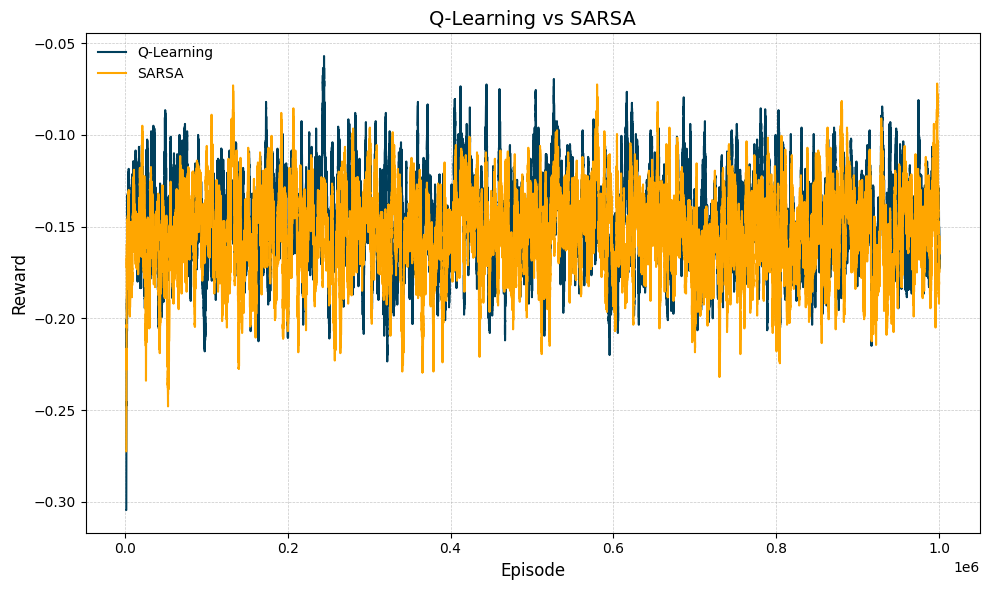

In [ ]:
import matplotlib.pyplot as plt

window = 2000
n_episodes = 1000000

smooth_q = np.convolve(rewards_q, np.ones(window)/window, mode='valid')
smooth_s = np.convolve(rewards_s, np.ones(window)/window, mode='valid')
smooth_episodes = np.arange(window, n_episodes + 1)

plt.figure(figsize=(10, 6))

plt.plot(smooth_episodes, smooth_q, label=f"Q‑Learning", color="#003f5c", linewidth=1.5)
plt.plot(smooth_episodes, smooth_s, label=f"SARSA",      color="#ffa600", linewidth=1.5)

plt.xlabel("Episode", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.title("Q‑Learning vs SARSA", fontsize=14)
plt.legend(frameon=False, fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
avg_reward_q = np.mean(rewards_q)
std_reward_q = np.std(rewards_q)
avg_reward_s = np.mean(rewards_s)
std_reward_s = np.std(rewards_s)
win_rate_q = 100 * sum(1 for r in rewards_q if r in (0, 1)) / len(rewards_q)
win_rate_s = 100 * sum(1 for r in rewards_s if r in (0, 1)) / len(rewards_s)


print("Q-Learning Agent:")
print(f"Average reward per episode: {avg_reward_q:.4f}")
print(f"Standard deviation: {std_reward_q:.4f}")
print(f"Win rate: {win_rate_q:.2f}%\n")

print("SARSA Agent:")
print(f"Average reward per episode: {avg_reward_s:.4f}")
print(f"Standard deviation: {std_reward_s:.4f}")
print(f"Win rate: {win_rate_s:.2f}%")

Q-Learning Agent:
Average reward per episode: -0.1469
Standard deviation: 1.0063
Win rate: 48.47%

SARSA Agent:
Average reward per episode: -0.1542
Standard deviation: 1.0061
Win rate: 48.12%


## **Peek Reward = -0.5**

In [ ]:
env = BlackjackNewEnv()

ft = polynomial_feature_transformer
ft_dim = len(ft(env.reset(), 0))
n_actions = env.action_space.n

q_agent = LinearAgent(
    feature_transformer=ft,
    n_actions=n_actions,
    n_features=ft_dim,
    alpha=0.1,
    gamma=0.9,
    epsilon=0.2,
    epsilon_decay=0.995,
    epsilon_min=0.05,
    method="q-learning",
    seed=42
)

s_agent = LinearAgent(
    feature_transformer=ft,
    n_actions=n_actions,
    n_features=ft_dim,
    alpha=0.1,
    gamma=0.9,
    epsilon=0.2,
    epsilon_decay=0.995,
    epsilon_min=0.05,
    method="sarsa",
    seed=42
)

In [ ]:
rewards_q = q_agent.train(env, n_episodes=1000000)
rewards_s = s_agent.train(env, n_episodes=1000000)

Training Episodes: 100%|██████████| 1000000/1000000 [06:30<00:00, 2558.52it/s]


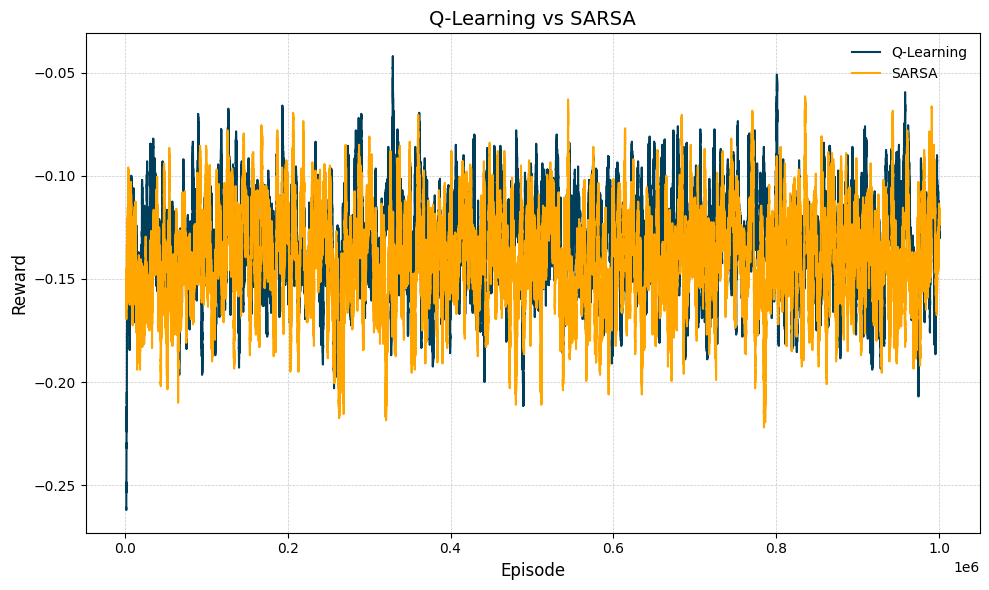

In [ ]:
window = 2000
n_episodes = 1000000

smooth_q = np.convolve(rewards_q, np.ones(window)/window, mode='valid')
smooth_s = np.convolve(rewards_s, np.ones(window)/window, mode='valid')
smooth_episodes = np.arange(window, n_episodes + 1)

plt.figure(figsize=(10, 6))

plt.plot(smooth_episodes, smooth_q, label=f"Q‑Learning", color="#003f5c", linewidth=1.5)
plt.plot(smooth_episodes, smooth_s, label=f"SARSA",      color="#ffa600", linewidth=1.5)

plt.xlabel("Episode", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.title("Q‑Learning vs SARSA", fontsize=14)
plt.legend(frameon=False, fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
avg_reward_q = np.mean(rewards_q)
std_reward_q = np.std(rewards_q)
avg_reward_s = np.mean(rewards_s)
std_reward_s = np.std(rewards_s)
win_rate_q = 100 * sum(1 for r in rewards_q if r in {1, 0.5, 0, -0.5}) / len(rewards_q)
win_rate_s = 100 * sum(1 for r in rewards_s if r in {1, 0.5, 0, -0.5}) / len(rewards_s)


print("Q-Learning Agent:")
print(f"Average reward per episode: {avg_reward_q:.4f}")
print(f"Standard deviation: {std_reward_q:.4f}")
print(f"Win rate: {win_rate_q:.2f}%\n")

print("SARSA Agent:")
print(f"Average reward per episode: {avg_reward_s:.4f}")
print(f"Standard deviation: {std_reward_s:.4f}")
print(f"Win rate: {win_rate_s:.2f}%")

Q-Learning Agent:
Average reward per episode: -0.1329
Standard deviation: 0.9790
Win rate: 49.49%

SARSA Agent:
Average reward per episode: -0.1401
Standard deviation: 0.9868
Win rate: 49.08%


## **Peek Reward = -2.0**

In [ ]:
env = BlackjackNewEnv()

ft = polynomial_feature_transformer
ft_dim = len(ft(env.reset(), 0))
n_actions = env.action_space.n

q_agent = LinearAgent(
    feature_transformer=ft,
    n_actions=n_actions,
    n_features=ft_dim,
    alpha=0.1,
    gamma=0.9,
    epsilon=0.2,
    epsilon_decay=0.995,
    epsilon_min=0.05,
    method="q-learning",
    seed=42
)

s_agent = LinearAgent(
    feature_transformer=ft,
    n_actions=n_actions,
    n_features=ft_dim,
    alpha=0.1,
    gamma=0.9,
    epsilon=0.2,
    epsilon_decay=0.995,
    epsilon_min=0.05,
    method="sarsa",
    seed=42
)

In [ ]:
rewards_q = q_agent.train(env, n_episodes=1000000)
rewards_s = s_agent.train(env, n_episodes=1000000)

Training Episodes: 100%|██████████| 1000000/1000000 [03:39<00:00, 4551.82it/s]


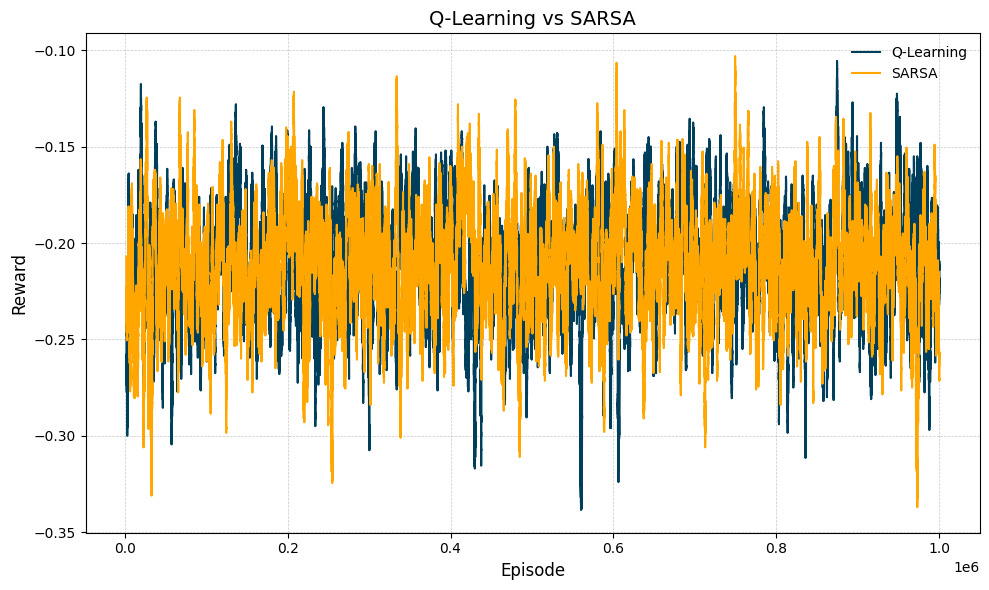

In [ ]:
import matplotlib.pyplot as plt

window = 2000
n_episodes = 1000000

smooth_q = np.convolve(rewards_q, np.ones(window)/window, mode='valid')
smooth_s = np.convolve(rewards_s, np.ones(window)/window, mode='valid')
smooth_episodes = np.arange(window, n_episodes + 1)

plt.figure(figsize=(10, 6))

plt.plot(smooth_episodes, smooth_q, label=f"Q‑Learning", color="#003f5c", linewidth=1.5)
plt.plot(smooth_episodes, smooth_s, label=f"SARSA",      color="#ffa600", linewidth=1.5)

plt.xlabel("Episode", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.title("Q‑Learning vs SARSA", fontsize=14)
plt.legend(frameon=False, fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
avg_reward_q = np.mean(rewards_q)
std_reward_q = np.std(rewards_q)
avg_reward_s = np.mean(rewards_s)
std_reward_s = np.std(rewards_s)
win_rate_q = 100 * sum(1 for r in rewards_q if r == 1) / len(rewards_q)
win_rate_s = 100 * sum(1 for r in rewards_s if r == 1) / len(rewards_s)


print("Q-Learning Agent:")
print(f"Average reward per episode: {avg_reward_q:.4f}")
print(f"Standard deviation: {std_reward_q:.4f}")
print(f"Win rate: {win_rate_q:.2f}%\n")

print("SARSA Agent:")
print(f"Average reward per episode: {avg_reward_s:.4f}")
print(f"Standard deviation: {std_reward_s:.4f}")
print(f"Win rate: {win_rate_s:.2f}%")

Q-Learning Agent:
Average reward per episode: -0.2108
Standard deviation: 1.1578
Win rate: 39.39%

SARSA Agent:
Average reward per episode: -0.2119
Standard deviation: 1.1560
Win rate: 39.33%


# **Training with Threshold Features**

## **Peek Reward = -1.0**

In [ ]:
env = BlackjackNewEnv()

ft = threshold_binary_transformer
ft_dim = len(ft(env.reset(), 0))
n_actions = env.action_space.n

q_agent = LinearAgent(
    feature_transformer=ft,
    n_actions=n_actions,
    n_features=ft_dim,
    alpha=0.1,
    gamma=0.9,
    epsilon=0.2,
    epsilon_decay=0.995,
    epsilon_min=0.05,
    method="q-learning",
    seed=42
)

s_agent = LinearAgent(
    feature_transformer=ft,
    n_actions=n_actions,
    n_features=ft_dim,
    alpha=0.1,
    gamma=0.9,
    epsilon=0.2,
    epsilon_decay=0.995,
    epsilon_min=0.05,
    method="sarsa",
    seed=42
)

In [ ]:
rewards_q = q_agent.train(env, n_episodes=1000000)
rewards_s = s_agent.train(env, n_episodes=1000000)

Training Episodes: 100%|██████████| 1000000/1000000 [01:25<00:00, 11737.05it/s]


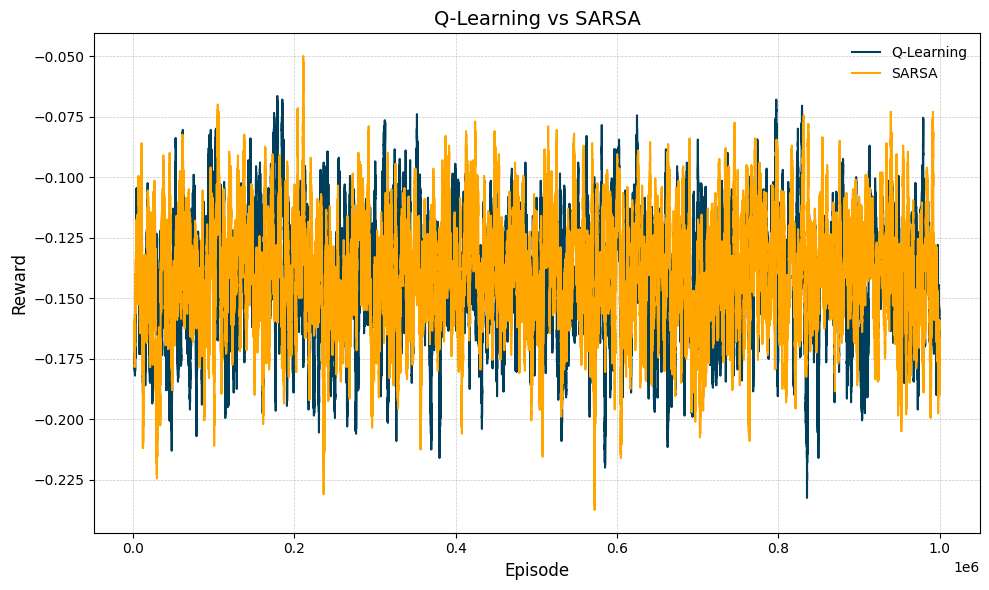

In [ ]:
import matplotlib.pyplot as plt

window = 2000
n_episodes = 1000000

smooth_q = np.convolve(rewards_q, np.ones(window)/window, mode='valid')
smooth_s = np.convolve(rewards_s, np.ones(window)/window, mode='valid')
smooth_episodes = np.arange(window, n_episodes + 1)

plt.figure(figsize=(10, 6))

plt.plot(smooth_episodes, smooth_q, label=f"Q‑Learning", color="#003f5c", linewidth=1.5)
plt.plot(smooth_episodes, smooth_s, label=f"SARSA",      color="#ffa600", linewidth=1.5)

plt.xlabel("Episode", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.title("Q‑Learning vs SARSA", fontsize=14)
plt.legend(frameon=False, fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
avg_reward_q = np.mean(rewards_q)
std_reward_q = np.std(rewards_q)
avg_reward_s = np.mean(rewards_s)
std_reward_s = np.std(rewards_s)
win_rate_q = 100 * sum(1 for r in rewards_q if r in (0, 1)) / len(rewards_q)
win_rate_s = 100 * sum(1 for r in rewards_s if r in (0, 1)) / len(rewards_s)


print("Q-Learning Agent:")
print(f"Average reward per episode: {avg_reward_q:.4f}")
print(f"Standard deviation: {std_reward_q:.4f}")
print(f"Win rate: {win_rate_q:.2f}%\n")

print("SARSA Agent:")
print(f"Average reward per episode: {avg_reward_s:.4f}")
print(f"Standard deviation: {std_reward_s:.4f}")
print(f"Win rate: {win_rate_s:.2f}%")

Q-Learning Agent:
Average reward per episode: -0.1417
Standard deviation: 1.0039
Win rate: 48.37%

SARSA Agent:
Average reward per episode: -0.1400
Standard deviation: 1.0045
Win rate: 48.45%


## **Peek Reward = -0.5**

In [4]:
env = BlackjackNewEnv()

ft = threshold_binary_transformer
ft_dim = len(ft(env.reset(), 0))
n_actions = env.action_space.n

q_agent = LinearAgent(
    feature_transformer=ft,
    n_actions=n_actions,
    n_features=ft_dim,
    alpha=0.1,
    gamma=0.9,
    epsilon=0.2,
    epsilon_decay=0.995,
    epsilon_min=0.05,
    method="q-learning",
    seed=42
)

s_agent = LinearAgent(
    feature_transformer=ft,
    n_actions=n_actions,
    n_features=ft_dim,
    alpha=0.1,
    gamma=0.9,
    epsilon=0.2,
    epsilon_decay=0.995,
    epsilon_min=0.05,
    method="sarsa",
    seed=42
)

In [5]:
rewards_q = q_agent.train(env, n_episodes=1000000)
rewards_s = s_agent.train(env, n_episodes=1000000)

Training Episodes: 100%|██████████| 1000000/1000000 [01:48<00:00, 9205.73it/s]


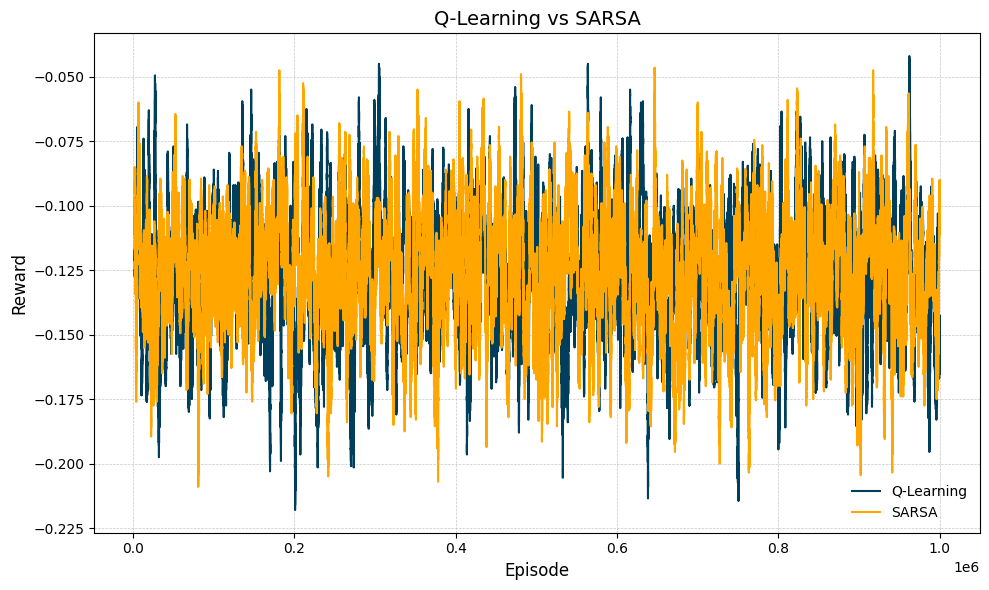

In [ ]:
import matplotlib.pyplot as plt


window = 2000
n_episodes = 1000000

smooth_q = np.convolve(rewards_q, np.ones(window)/window, mode='valid')
smooth_s = np.convolve(rewards_s, np.ones(window)/window, mode='valid')
smooth_episodes = np.arange(window, n_episodes + 1)

plt.figure(figsize=(10, 6))

plt.plot(smooth_episodes, smooth_q, label=f"Q‑Learning", color="#003f5c", linewidth=1.5)
plt.plot(smooth_episodes, smooth_s, label=f"SARSA",      color="#ffa600", linewidth=1.5)

plt.xlabel("Episode", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.title("Q‑Learning vs SARSA", fontsize=14)
plt.legend(frameon=False, fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [6]:
avg_reward_q = np.mean(rewards_q)
std_reward_q = np.std(rewards_q)
avg_reward_s = np.mean(rewards_s)
std_reward_s = np.std(rewards_s)
win_rate_q = 100 * sum(1 for r in rewards_q if r in {1, 0.5, 0, -0.5}) / len(rewards_q)
win_rate_s = 100 * sum(1 for r in rewards_s if r in {1, 0.5, 0, -0.5}) / len(rewards_s)


print("Q-Learning Agent:")
print(f"Average reward per episode: {avg_reward_q:.4f}")
print(f"Standard deviation: {std_reward_q:.4f}")
print(f"Win rate: {win_rate_q:.2f}%\n")

print("SARSA Agent:")
print(f"Average reward per episode: {avg_reward_s:.4f}")
print(f"Standard deviation: {std_reward_s:.4f}")
print(f"Win rate: {win_rate_s:.2f}%")

Q-Learning Agent:
Average reward per episode: -0.1251
Standard deviation: 0.9748
Win rate: 49.25%

SARSA Agent:
Average reward per episode: -0.1249
Standard deviation: 0.9800
Win rate: 49.19%


## **Peek Reward = -2.0**

In [ ]:
env = BlackjackNewEnv()

ft = threshold_binary_transformer
ft_dim = len(ft(env.reset(), 0))
n_actions = env.action_space.n

q_agent = LinearAgent(
    feature_transformer=ft,
    n_actions=n_actions,
    n_features=ft_dim,
    alpha=0.1,
    gamma=0.9,
    epsilon=0.2,
    epsilon_decay=0.995,
    epsilon_min=0.05,
    method="q-learning",
    seed=42
)

s_agent = LinearAgent(
    feature_transformer=ft,
    n_actions=n_actions,
    n_features=ft_dim,
    alpha=0.1,
    gamma=0.9,
    epsilon=0.2,
    epsilon_decay=0.995,
    epsilon_min=0.05,
    method="sarsa",
    seed=42
)

In [ ]:
rewards_q = q_agent.train(env, n_episodes=1000000)
rewards_s = s_agent.train(env, n_episodes=1000000)

Training Episodes: 100%|██████████| 1000000/1000000 [00:51<00:00, 19375.71it/s]


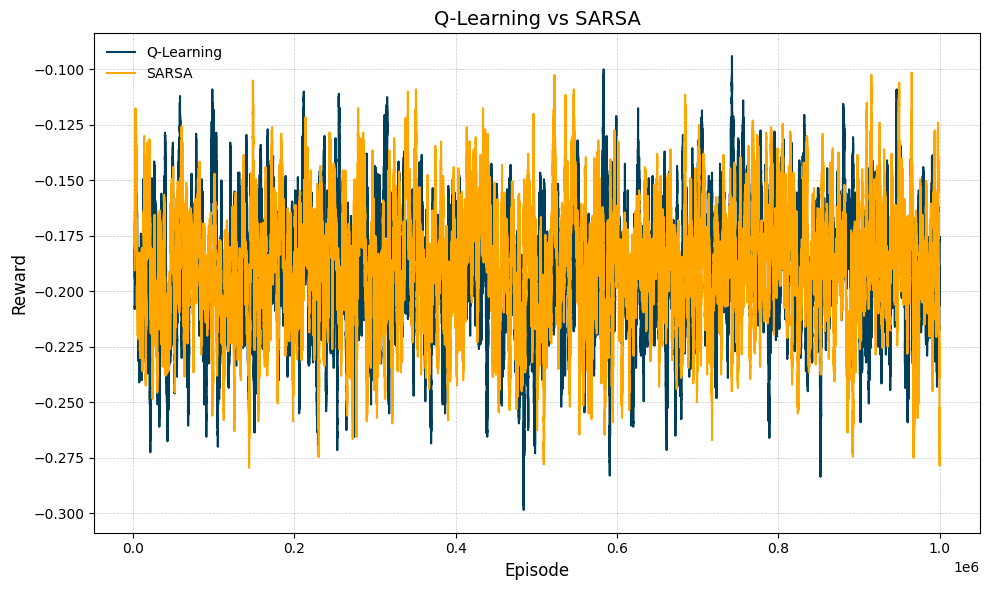

In [ ]:
import matplotlib.pyplot as plt

window = 2000
n_episodes = 1000000

smooth_q = np.convolve(rewards_q, np.ones(window)/window, mode='valid')
smooth_s = np.convolve(rewards_s, np.ones(window)/window, mode='valid')
smooth_episodes = np.arange(window, n_episodes + 1)

plt.figure(figsize=(10, 6))

plt.plot(smooth_episodes, smooth_q, label=f"Q‑Learning", color="#003f5c", linewidth=1.5)
plt.plot(smooth_episodes, smooth_s, label=f"SARSA",      color="#ffa600", linewidth=1.5)

plt.xlabel("Episode", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.title("Q‑Learning vs SARSA", fontsize=14)
plt.legend(frameon=False, fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
avg_reward_q = np.mean(rewards_q)
std_reward_q = np.std(rewards_q)
avg_reward_s = np.mean(rewards_s)
std_reward_s = np.std(rewards_s)
win_rate_q = 100 * sum(1 for r in rewards_q if r == 1) / len(rewards_q)
win_rate_s = 100 * sum(1 for r in rewards_s if r == 1) / len(rewards_s)


print("Q-Learning Agent:")
print(f"Average reward per episode: {avg_reward_q:.4f}")
print(f"Standard deviation: {std_reward_q:.4f}")
print(f"Win rate: {win_rate_q:.2f}%\n")

print("SARSA Agent:")
print(f"Average reward per episode: {avg_reward_s:.4f}")
print(f"Standard deviation: {std_reward_s:.4f}")
print(f"Win rate: {win_rate_s:.2f}%")

Q-Learning Agent:
Average reward per episode: -0.1907
Standard deviation: 1.1437
Win rate: 40.23%

SARSA Agent:
Average reward per episode: -0.1891
Standard deviation: 1.1445
Win rate: 40.33%


# **Performance Comparison**

In [16]:
# RANDOM STRATEGY

import numpy as np
import random
from tqdm import trange
from datetime import datetime

random.seed(23)

def random_strategy(player_sum):
    return random.choice([BlackjackNewEnv.hit, BlackjackNewEnv.stand, BlackjackNewEnv.peek])

env = BlackjackNewEnv()
num_games = 1000000
rewards_random = []

for _ in trange(num_games, desc="Simulating Games"):

    obs = env.reset()

    if env.deck.has_reshuffled_since_last_hand():
        env.deck.clear_reshuffled_flag()

    player_hand = env.player
    dealer_hand = env.dealer

    done = False
    while not done:
        player_sum, dealer_card, has_usable_ace, peeked = obs
        action = random_strategy(player_sum)

        obs, reward, done, _ = env.step(action)


    rewards_random.append(reward)

Simulating Games: 100%|██████████| 1000000/1000000 [00:30<00:00, 32786.09it/s]


In [17]:
avg_reward_random = np.mean(rewards_random)
std_reward_random = np.std(rewards_random)
win_rate_random = 100 * sum(1 for r in rewards_random if r in {1, 0.5, 0, -0.5}) / num_games

print("Random Agent:")
print(f"Average reward per episode: {avg_reward_random:.4f}")
print(f"Standard deviation: {std_reward_random:.4f}")
print(f"Win rate: {win_rate_random:.2f}%\n")

Random Agent:
Average reward per episode: -0.7389
Standard deviation: 1.0387
Win rate: 30.82%



In [23]:
# BASIC STRATEGY

import numpy as np
import random
from tqdm import trange
from datetime import datetime


random.seed(23)

def basic_strategy(player_sum, peeked):
  if peeked == 0:
    if random.random() <= 0.8:
      return BlackjackNewEnv.hit if player_sum < 18 else BlackjackNewEnv.stand
    else:
      return BlackjackNewEnv.peek
  else:
    if player_sum + peeked <= 21:
      return BlackjackNewEnv.hit
    else:
      return BlackjackNewEnv.stand


env = BlackjackNewEnv()
num_games = 1000000
rewards_basic = []

for _ in trange(num_games, desc="Simulating Games"):

    obs = env.reset()

    if env.deck.has_reshuffled_since_last_hand():
        env.deck.clear_reshuffled_flag()

    player_hand = env.player
    dealer_hand = env.dealer

    done = False
    while not done:
        player_sum, dealer_card, has_usable_ace, peeked = obs
        action = basic_strategy(player_sum, peeked)

        obs, reward, done, _ = env.step(action)


    rewards_basic.append(reward)

Simulating Games: 100%|██████████| 1000000/1000000 [00:18<00:00, 54581.51it/s]


In [24]:
avg_reward_basic = np.mean(rewards_basic)
std_reward_basic = np.std(rewards_basic)
win_rate_basic   = 100 * sum(1 for r in rewards_basic if r in {1, 0.5, 0, -0.5}) / num_games

print("Basic Agent:")
print(f"Average reward per episode: {avg_reward_basic:.4f}")
print(f"Standard deviation: {std_reward_basic:.4f}")
print(f"Win rate: {win_rate_basic:.2f}%\n")

Basic Agent:
Average reward per episode: -0.3228
Standard deviation: 1.0109
Win rate: 47.71%



/tmp/ipython-input-40-1201945754.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


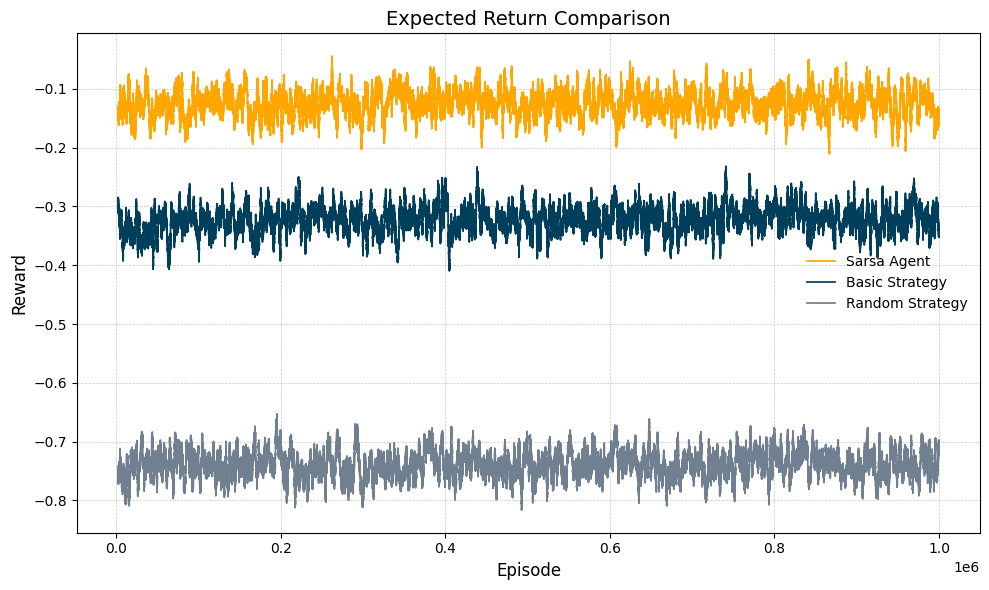

In [40]:
import numpy as np
import matplotlib.pyplot as plt

window = 2000
n_episodes = 1000000

smooth_s      = np.convolve(rewards_s,      np.ones(window)/window, mode='valid')
smooth_random = np.convolve(rewards_random, np.ones(window)/window, mode='valid')
smooth_basic  = np.convolve(rewards_basic,  np.ones(window)/window, mode='valid')

smooth_episodes = np.arange(window, n_episodes + 1)

plt.figure(figsize=(10, 6))

plt.plot(smooth_episodes, smooth_s, label="Sarsa Agent", color="#ffa600", linewidth=1.25)
plt.plot(smooth_episodes, smooth_basic, label="Basic Strategy", color="#003f5c", linewidth=1.25)
plt.plot(smooth_episodes, smooth_random, label="Random Strategy", color="slategray", linewidth=1.25)

plt.xlabel("Episode", fontsize=12)
plt.ylabel("Reward",  fontsize=12)
plt.title("Expected Return Comparison", fontsize=14)

plt.legend(frameon=False, fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


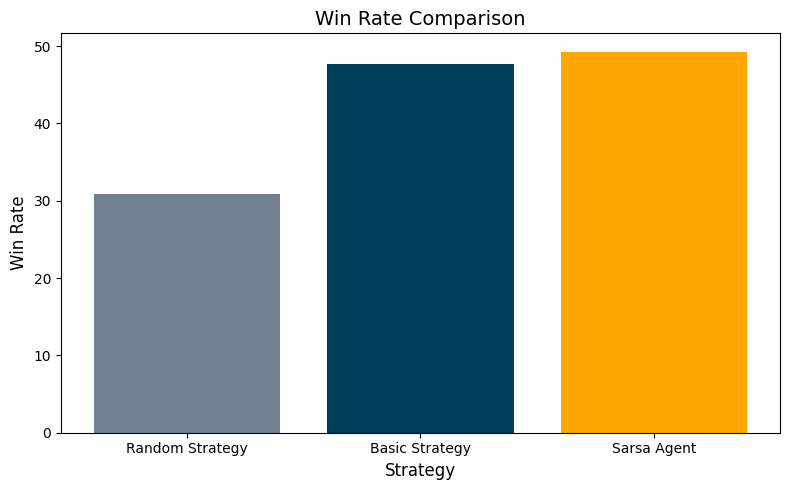

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar("Random Strategy", win_rate_random, color="slategray")
plt.bar("Basic Strategy", win_rate_basic, color="#003f5c")
plt.bar("Sarsa Agent", win_rate_s, color="#ffa600")
plt.xlabel("Strategy", fontsize=12)
plt.ylabel("Win Rate", fontsize=12)
plt.title("Win Rate Comparison", fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
